# Sample Analysis on [Titanic Survival Analysis](https://www.kaggle.com/c/titanic)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

%matplotlib inline

In [2]:
spark = SparkSession.builder \
        .appName('Titanic_Survival_Prediction') \
        .getOrCreate()
        
spark

# Load Titanic Dataset

In [3]:
data = spark.read.csv('./pyspark-examples/data/titanic.csv', header=True, inferSchema=True, sep=',').cache()
data.show(n=5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [4]:
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [5]:
used_cols = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Survived']
data = data.select(*used_cols).cache()
data.show(n=5)

+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+
|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Cabin|Embarked|Survived|
+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+
|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25| null|       S|       0|
|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|  C85|       C|       1|
|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925| null|       S|       1|
|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1| C123|       S|       1|
|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05| null|       S|       0|
+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+
only showing top 5 rows



In [6]:
# describe
data.select('Pclass', 'Age', 'SibSp', 'Parch', 'Fare').describe().show()

+-------+------------------+------------------+------------------+-------------------+-----------------+
|summary|            Pclass|               Age|             SibSp|              Parch|             Fare|
+-------+------------------+------------------+------------------+-------------------+-----------------+
|  count|               891|               714|               891|                891|              891|
|   mean| 2.308641975308642| 29.69911764705882|0.5230078563411896|0.38159371492704824| 32.2042079685746|
| stddev|0.8360712409770491|14.526497332334035|1.1027434322934315| 0.8060572211299488|49.69342859718089|
|    min|                 1|              0.42|                 0|                  0|              0.0|
|    max|                 3|              80.0|                 8|                  6|         512.3292|
+-------+------------------+------------------+------------------+-------------------+-----------------+



In [7]:
# total count
data.count()

891

In [8]:
# count for each class
data.groupBy('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [9]:
# another way to check missing values
def count_missing(df):
    miss_counts = []
    total_cnt = df.count()
    for name in df.columns:
        cnt = df.filter(df[name].isNull()).count()
        miss_counts.append((name, cnt, cnt / total_cnt))
        
    return miss_counts

missing_counts = count_missing(data)
spark.createDataFrame(missing_counts, ['column', 'miss counts', 'miss ratio']).show()

+--------+-----------+--------------------+
|  column|miss counts|          miss ratio|
+--------+-----------+--------------------+
|  Pclass|          0|                 0.0|
|    Name|          0|                 0.0|
|     Sex|          0|                 0.0|
|     Age|        177| 0.19865319865319866|
|   SibSp|          0|                 0.0|
|   Parch|          0|                 0.0|
|    Fare|          0|                 0.0|
|   Cabin|        687|  0.7710437710437711|
|Embarked|          2|0.002244668911335578|
|Survived|          0|                 0.0|
+--------+-----------+--------------------+



In [10]:
# check missing values
data.agg(*[(891 - F.count(c)).alias(c) for c in data.columns]).show()

+------+----+---+---+-----+-----+----+-----+--------+--------+
|Pclass|Name|Sex|Age|SibSp|Parch|Fare|Cabin|Embarked|Survived|
+------+----+---+---+-----+-----+----+-----+--------+--------+
|     0|   0|  0|177|    0|    0|   0|  687|       2|       0|
+------+----+---+---+-----+-----+----+-----+--------+--------+



In [11]:
# check distinct values
data.agg(*[F.countDistinct(c).alias(c) for c in data.columns]).show()

+------+----+---+---+-----+-----+----+-----+--------+--------+
|Pclass|Name|Sex|Age|SibSp|Parch|Fare|Cabin|Embarked|Survived|
+------+----+---+---+-----+-----+----+-----+--------+--------+
|     3| 891|  2| 88|    7|    7| 248|  147|       3|       2|
+------+----+---+---+-----+-----+----+-----+--------+--------+



In [12]:
# check unique values
for name in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked']:
    unique_values = data.select(name).distinct().collect()
    tmp = []
    for val in unique_values:
        tmp.append(val[0])
    print(name, '\t', tmp)

Pclass 	 [1, 3, 2]
Sex 	 ['female', 'male']
SibSp 	 [1, 3, 5, 4, 8, 2, 0]
Parch 	 [1, 6, 3, 5, 4, 2, 0]
Cabin 	 ['A23', 'B79', 'E44', 'F E69', 'D28', 'C78', 'C95', 'F G73', 'B58 B60', 'D7', 'C128', 'B39', 'B22', 'C110', 'D21', 'F2', 'B30', 'C104', 'B50', 'A6', 'E31', 'C90', 'D45', 'C45', 'C65', 'C22 C26', 'A19', 'B51 B53 B55', 'E33', 'A16', 'B4', 'B96 B98', 'E10', 'C82', 'D20', 'E77', 'B38', 'E8', 'A32', 'C87', 'B20', 'E50', 'B80', 'D48', 'E49', None, 'T', 'A36', 'C123', 'D37', 'C83', 'C62 C64', 'C103', 'D35', 'C111', 'F G63', 'C126', 'D15', 'B18', 'C54', 'E121', 'D46', 'B19', 'C68', 'C50', 'C93', 'E36', 'D', 'E46', 'C124', 'C30', 'E101', 'A26', 'G6', 'C85', 'B3', 'D47', 'B28', 'B71', 'A31', 'E67', 'C148', 'A10', 'D30', 'D19', 'B37', 'E25', 'C86', 'A20', 'E40', 'D17', 'C52', 'C91', 'B77', 'B86', 'D33', 'B94', 'D10 D12', 'D49', 'C23 C25 C27', 'D9', 'F4', 'B102', 'F33', 'B5', 'E24', 'E63', 'A14', 'A24', 'C92', 'A7', 'D36', 'C46', 'E34', 'E12', 'D50', 'B101', 'C99', 'E38', 'C47', 'D26', '

In [13]:
# check feature 'Embarked'
data.groupby('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



# Feature Engineering

In [14]:
data.show(5)

+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+
|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Cabin|Embarked|Survived|
+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+
|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25| null|       S|       0|
|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|  C85|       C|       1|
|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925| null|       S|       1|
|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1| C123|       S|       1|
|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05| null|       S|       0|
+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+
only showing top 5 rows



### Impute Missing Values for 'Age' and 'Embarked'

In [15]:
# for feature 'Name', it's useful to extract the title
data = data.withColumn('Title', F.regexp_extract(data['Name'], '([A-Za-z]+)\.', 1))
data.show(5)

+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+-----+
|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Cabin|Embarked|Survived|Title|
+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+-----+
|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25| null|       S|       0|   Mr|
|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|  C85|       C|       1|  Mrs|
|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925| null|       S|       1| Miss|
|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1| C123|       S|       1|  Mrs|
|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05| null|       S|       0|   Mr|
+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+-----+
only showing top 5 rows



In [16]:
data.groupby('Title').count().show()

+--------+-----+
|   Title|count|
+--------+-----+
|     Don|    1|
|    Miss|  182|
|Countess|    1|
|     Col|    2|
|     Rev|    6|
|    Lady|    1|
|  Master|   40|
|     Mme|    1|
|    Capt|    1|
|      Mr|  517|
|      Dr|    7|
|     Mrs|  125|
|     Sir|    1|
|Jonkheer|    1|
|    Mlle|    2|
|   Major|    2|
|      Ms|    1|
+--------+-----+



In [17]:
# replace title
original = ['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 
            'Col', 'Rev', 'Capt', 'Sir', 'Don']
to_values = ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 
             'Other', 'Other', 'Mr', 'Mr', 'Mr']
data = data.replace(original, to_values, 'Title')
data.show(5)

+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+-----+
|Pclass|                Name|   Sex| Age|SibSp|Parch|   Fare|Cabin|Embarked|Survived|Title|
+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+-----+
|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|   7.25| null|       S|       0|   Mr|
|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|71.2833|  C85|       C|       1|  Mrs|
|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|  7.925| null|       S|       1| Miss|
|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|   53.1| C123|       S|       1|  Mrs|
|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|   8.05| null|       S|       0|   Mr|
+------+--------------------+------+----+-----+-----+-------+-----+--------+--------+-----+
only showing top 5 rows



In [18]:
# check age information
data.groupby('Title').mean('Age').collect()

[Row(Title='Miss', avg(Age)=21.86),
 Row(Title='Other', avg(Age)=45.888888888888886),
 Row(Title='Master', avg(Age)=4.574166666666667),
 Row(Title='Mr', avg(Age)=32.73960880195599),
 Row(Title='Mrs', avg(Age)=35.981818181818184)]

In [19]:
# replace missing 'Age' with mean values
data = data.withColumn('Age', F.when((data['Title'] == 'Miss') & (data['Age'].isNull()), 22).otherwise(data['Age']))
data = data.withColumn('Age', F.when((data['Title'] == 'Other') & (data['Age'].isNull()), 46).otherwise(data['Age']))
data = data.withColumn('Age', F.when((data['Title'] == 'Master') & (data['Age'].isNull()), 5).otherwise(data['Age']))
data = data.withColumn('Age', F.when((data['Title'] == 'Mr') & (data['Age'].isNull()), 33).otherwise(data['Age']))
data = data.withColumn('Age', F.when((data['Title'] == 'Mrs') & (data['Age'].isNull()), 36).otherwise(data['Age']))

In [20]:
# replace missing 'Embarked' with 'S'
data = data.na.fill({'Embarked': 'S'})

### Drop Useless Features

In [21]:
# drop feature 'Name', 'Cabin'
data = data.drop('Name', 'Cabin')
data.show(5)

+------+------+----+-----+-----+-------+--------+--------+-----+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|Title|
+------+------+----+-----+-----+-------+--------+--------+-----+
|     3|  male|22.0|    1|    0|   7.25|       S|       0|   Mr|
|     1|female|38.0|    1|    0|71.2833|       C|       1|  Mrs|
|     3|female|26.0|    0|    0|  7.925|       S|       1| Miss|
|     1|female|35.0|    1|    0|   53.1|       S|       1|  Mrs|
|     3|  male|35.0|    0|    0|   8.05|       S|       0|   Mr|
+------+------+----+-----+-----+-------+--------+--------+-----+
only showing top 5 rows



In [22]:
# check missing values
def count_missing(df):
    miss_counts = []
    total_cnt = df.count()
    for name in df.columns:
        cnt = df.filter(df[name].isNull()).count()
        miss_counts.append((name, cnt, cnt / total_cnt))
        
    return miss_counts

missing_counts = count_missing(data)
spark.createDataFrame(missing_counts, ['column', 'miss counts', 'miss ratio']).show()

+--------+-----------+----------+
|  column|miss counts|miss ratio|
+--------+-----------+----------+
|  Pclass|          0|       0.0|
|     Sex|          0|       0.0|
|     Age|          0|       0.0|
|   SibSp|          0|       0.0|
|   Parch|          0|       0.0|
|    Fare|          0|       0.0|
|Embarked|          0|       0.0|
|Survived|          0|       0.0|
|   Title|          0|       0.0|
+--------+-----------+----------+



### New Features for 'Family Size' and Binary 'Alone'

In [23]:
# create feature 'Family'
data = data.withColumn('Family', data['SibSp'] + data['Parch'])
data.show(5)

+------+------+----+-----+-----+-------+--------+--------+-----+------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|Title|Family|
+------+------+----+-----+-----+-------+--------+--------+-----+------+
|     3|  male|22.0|    1|    0|   7.25|       S|       0|   Mr|     1|
|     1|female|38.0|    1|    0|71.2833|       C|       1|  Mrs|     1|
|     3|female|26.0|    0|    0|  7.925|       S|       1| Miss|     0|
|     1|female|35.0|    1|    0|   53.1|       S|       1|  Mrs|     1|
|     3|  male|35.0|    0|    0|   8.05|       S|       0|   Mr|     0|
+------+------+----+-----+-----+-------+--------+--------+-----+------+
only showing top 5 rows



In [24]:
# create feature 'Alone'
data = data.withColumn('Alone', F.lit(0))
data = data.withColumn('Alone', F.when(data['Family'] == 0, 1).otherwise(data['Alone']))
data.show(5)

+------+------+----+-----+-----+-------+--------+--------+-----+------+-----+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|Title|Family|Alone|
+------+------+----+-----+-----+-------+--------+--------+-----+------+-----+
|     3|  male|22.0|    1|    0|   7.25|       S|       0|   Mr|     1|    0|
|     1|female|38.0|    1|    0|71.2833|       C|       1|  Mrs|     1|    0|
|     3|female|26.0|    0|    0|  7.925|       S|       1| Miss|     0|    1|
|     1|female|35.0|    1|    0|   53.1|       S|       1|  Mrs|     1|    0|
|     3|  male|35.0|    0|    0|   8.05|       S|       0|   Mr|     0|    1|
+------+------+----+-----+-----+-------+--------+--------+-----+------+-----+
only showing top 5 rows



### Encoding Categorical Features

In [25]:
# StringIndexer + OneHotEncoderEstimator
stages = []
indexer = StringIndexer(inputCol='Sex', outputCol='Sex_index')
stages += [indexer]

indexer = StringIndexer(inputCol='Embarked', outputCol='Embarked_index')
encoder = OneHotEncoderEstimator(inputCols=['Embarked_index'], outputCols=['Embarked_onehot'])
stages += [indexer, encoder]

indexer = StringIndexer(inputCol='Title', outputCol='Title_index')
encoder = OneHotEncoderEstimator(inputCols=['Title_index'], outputCols=['Title_onehot'])
stages += [indexer, encoder]

In [26]:
# build pipeline
pipeline = Pipeline(stages=stages)
data = pipeline.fit(data).transform(data)

In [27]:
# drop useless features
data = data.drop('Sex', 'Embarked', 'Embarked_index', 'Title', 'Title_index')
data.show(5)

+------+----+-----+-----+-------+--------+------+-----+---------+---------------+-------------+
|Pclass| Age|SibSp|Parch|   Fare|Survived|Family|Alone|Sex_index|Embarked_onehot| Title_onehot|
+------+----+-----+-----+-------+--------+------+-----+---------+---------------+-------------+
|     3|22.0|    1|    0|   7.25|       0|     1|    0|      0.0|  (2,[0],[1.0])|(4,[0],[1.0])|
|     1|38.0|    1|    0|71.2833|       1|     1|    0|      1.0|  (2,[1],[1.0])|(4,[2],[1.0])|
|     3|26.0|    0|    0|  7.925|       1|     0|    1|      1.0|  (2,[0],[1.0])|(4,[1],[1.0])|
|     1|35.0|    1|    0|   53.1|       1|     1|    0|      1.0|  (2,[0],[1.0])|(4,[2],[1.0])|
|     3|35.0|    0|    0|   8.05|       0|     0|    1|      0.0|  (2,[0],[1.0])|(4,[0],[1.0])|
+------+----+-----+-----+-------+--------+------+-----+---------+---------------+-------------+
only showing top 5 rows



In [28]:
data.columns

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Survived',
 'Family',
 'Alone',
 'Sex_index',
 'Embarked_onehot',
 'Title_onehot']

### VectorAssembler All Features

In [29]:
input_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family', 'Alone', 
              'Sex_index', 'Embarked_onehot', 'Title_onehot']
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
feature_vector = assembler.transform(data)

feature_vector.show(5)

+------+----+-----+-----+-------+--------+------+-----+---------+---------------+-------------+--------------------+
|Pclass| Age|SibSp|Parch|   Fare|Survived|Family|Alone|Sex_index|Embarked_onehot| Title_onehot|            features|
+------+----+-----+-----+-------+--------+------+-----+---------+---------------+-------------+--------------------+
|     3|22.0|    1|    0|   7.25|       0|     1|    0|      0.0|  (2,[0],[1.0])|(4,[0],[1.0])|(14,[0,1,2,4,5,8,...|
|     1|38.0|    1|    0|71.2833|       1|     1|    0|      1.0|  (2,[1],[1.0])|(4,[2],[1.0])|(14,[0,1,2,4,5,7,...|
|     3|26.0|    0|    0|  7.925|       1|     0|    1|      1.0|  (2,[0],[1.0])|(4,[1],[1.0])|(14,[0,1,4,6,7,8,...|
|     1|35.0|    1|    0|   53.1|       1|     1|    0|      1.0|  (2,[0],[1.0])|(4,[2],[1.0])|(14,[0,1,2,4,5,7,...|
|     3|35.0|    0|    0|   8.05|       0|     0|    1|      0.0|  (2,[0],[1.0])|(4,[0],[1.0])|(14,[0,1,4,6,8,10...|
+------+----+-----+-----+-------+--------+------+-----+---------

In [30]:
# split into training and test data
(train, test) = feature_vector.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression

In [31]:
# fit logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='Survived', predictionCol='prediction', 
                        maxIter=100, threshold=0.5, probabilityCol='probability', standardization=True)

lr_model = lr.fit(train)
lr_train_pred = lr_model.transform(train)
lr_test_pred = lr_model.transform(test)

lr_test_pred.select('Survived', 'rawPrediction', 'probability', 'prediction').show(5)

+--------+--------------------+--------------------+----------+
|Survived|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+----------+
|       0|[-2.7500620756740...|[0.06008314446878...|       1.0|
|       1|[-3.7980920648544...|[0.02192214275334...|       1.0|
|       1|[-2.9476068952489...|[0.04984973831912...|       1.0|
|       0|[-0.4750484670391...|[0.38342203734162...|       1.0|
|       1|[-2.8961950335324...|[0.05234197698824...|       1.0|
+--------+--------------------+--------------------+----------+
only showing top 5 rows



In [32]:
# model evaluation
evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')

lr_train_auc = evaluator.evaluate(lr_train_pred)
lr_test_auc = evaluator.evaluate(lr_test_pred)

print('Train AUC: {:6.4f}\t Test AUC: {:6.4f}'.format(lr_train_auc, lr_test_auc))

Train AUC: 0.8791	 Test AUC: 0.8699


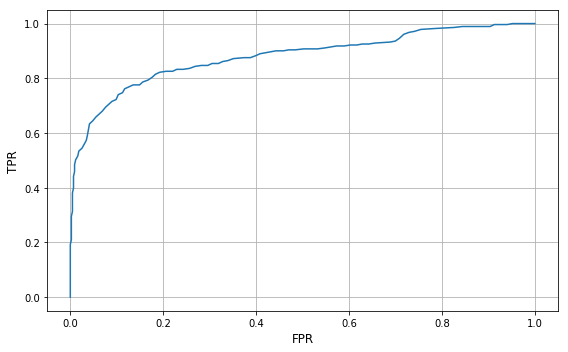

In [33]:
# visualize training ROC curve
lr_roc = lr_model.summary.roc.toPandas()

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(lr_roc['FPR'], lr_roc['TPR'])
ax.set_xlabel('FPR', fontsize=12)
ax.set_ylabel('TPR', fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

# Decision Tree

In [34]:
# fit logistic regression model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Survived', maxDepth=15, 
                            checkpointInterval=10, impurity='gini', seed=42)

dt_model = dt.fit(train)
dt_train_pred = dt_model.transform(train)
dt_test_pred = dt_model.transform(test)

dt_test_pred.select('Survived', 'rawPrediction', 'probability', 'prediction').show(5)

+--------+-------------+-----------+----------+
|Survived|rawPrediction|probability|prediction|
+--------+-------------+-----------+----------+
|       0|    [0.0,9.0]|  [0.0,1.0]|       1.0|
|       1|   [0.0,16.0]|  [0.0,1.0]|       1.0|
|       1|   [0.0,16.0]|  [0.0,1.0]|       1.0|
|       0|    [6.0,0.0]|  [1.0,0.0]|       0.0|
|       1|   [0.0,25.0]|  [0.0,1.0]|       1.0|
+--------+-------------+-----------+----------+
only showing top 5 rows



In [35]:
# model evaluation
evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')

dt_train_auc = evaluator.evaluate(dt_train_pred)
dt_test_auc = evaluator.evaluate(dt_test_pred)

print('Train AUC: {:6.4f}\t Test AUC: {:6.4f}'.format(dt_train_auc, dt_test_auc))

Train AUC: 0.9042	 Test AUC: 0.7106


# Gradient-Boosted Trees (GBTs)

In [36]:
# fit logistic regression model
gbt = GBTClassifier(featuresCol='features', labelCol='Survived', maxDepth=3, maxBins=32, 
                    minInstancesPerNode=1, minInfoGain=0.0, checkpointInterval=10, lossType='logistic', 
                    maxIter=50, stepSize=0.1, seed=42, subsamplingRate=1.0, featureSubsetStrategy='auto')

gbt_model = gbt.fit(train)
gbt_train_pred = gbt_model.transform(train)
gbt_test_pred = gbt_model.transform(test)

gbt_test_pred.select('Survived', 'rawPrediction', 'probability', 'prediction').show(5)

+--------+--------------------+--------------------+----------+
|Survived|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+----------+
|       0|[-1.8863656631742...|[0.02247256060051...|       1.0|
|       1|[-1.6713612516370...|[0.03413428518068...|       1.0|
|       1|[-1.0514697578142...|[0.10881144396460...|       1.0|
|       0|[0.07988673448481...|[0.53985861219819...|       0.0|
|       1|[-1.2919002174005...|[0.07018830177856...|       1.0|
+--------+--------------------+--------------------+----------+
only showing top 5 rows



In [37]:
# model evaluation
evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')

gbt_train_auc = evaluator.evaluate(gbt_train_pred)
gbt_test_auc = evaluator.evaluate(gbt_test_pred)

print('Train AUC: {:6.4f}\t Test AUC: {:6.4f}'.format(gbt_train_auc, gbt_test_auc))

Train AUC: 0.9337	 Test AUC: 0.8910


# Random Forest

In [38]:
# fit logistic regression model
rf = RandomForestClassifier(featuresCol='features', labelCol='Survived', maxDepth=7, impurity='gini', 
                            numTrees=50, featureSubsetStrategy='auto', seed=42, subsamplingRate=1.0)

rf_model = rf.fit(train)
rf_train_pred = rf_model.transform(train)
rf_test_pred = rf_model.transform(test)

rf_test_pred.select('Survived', 'rawPrediction', 'probability', 'prediction').show(5)

+--------+--------------------+--------------------+----------+
|Survived|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+----------+
|       0|[1.65525316242178...|[0.03310506324843...|       1.0|
|       1|[4.22423135225733...|[0.08448462704514...|       1.0|
|       1|[13.2036317151670...|[0.26407263430334...|       1.0|
|       0|[29.4119063888178...|[0.58823812777635...|       0.0|
|       1|[2.53900964614737...|[0.05078019292294...|       1.0|
+--------+--------------------+--------------------+----------+
only showing top 5 rows



In [39]:
# model evaluation
evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')

rf_train_auc = evaluator.evaluate(rf_train_pred)
rf_test_auc = evaluator.evaluate(rf_test_pred)

print('Train AUC: {:6.4f}\t Test AUC: {:6.4f}'.format(rf_train_auc, rf_test_auc))

Train AUC: 0.9349	 Test AUC: 0.8938


In [40]:
# stop spark server
spark.stop()